In [1]:
from keras.models import Sequential
from keras import layers
import numpy as np
from six.moves import range

Using TensorFlow backend.


# Parameters Config

In [2]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [3]:
DATA_SIZE = 100000
TRAINING_SIZE = 50000
TESTING_SIZE = 50000
DIGITS = 3
EPOCHS = 200
REVERSE = False
MAXLEN = DIGITS + 1 + DIGITS
chars = '0123456789- '
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

trainingOutputPath = 'd' + str(DIGITS) + 'e' + str(EPOCHS) + 's' + str((TRAINING_SIZE - TRAINING_SIZE/10)/1000)+'.csv' 

In [4]:
class CharacterTable(object):
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
    
    def encode(self, C, num_rows):
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x
    
    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return "".join(self.indices_char[i] for i in x)

In [5]:
ctable = CharacterTable(chars)

In [6]:
ctable.indices_char

{0: ' ',
 1: '-',
 2: '0',
 3: '1',
 4: '2',
 5: '3',
 6: '4',
 7: '5',
 8: '6',
 9: '7',
 10: '8',
 11: '9'}

# Data Generation

In [7]:
questions = []
expected = []
seen = set()
print('Generating data...')
while len(questions) < DATA_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    q = '{}-{}'.format(a, b)
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(a - b)
    ans += ' ' * (DIGITS + 1 - len(ans))
    if REVERSE:
        query = query[::-1]
    questions.append(query)
    expected.append(ans)
print('Total addition questions:', len(questions))

Generating data...
Total addition questions: 100000


In [8]:
print(questions[:5], expected[:5])

['99-5   ', '0-351  ', '33-1   ', '246-961', '9-48   '] ['94  ', '-351', '32  ', '-715', '-39 ']


# Processing

In [9]:
print('Vectorization...')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(expected), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)

Vectorization...


In [10]:
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# train_test_split
train_x = x[:TRAINING_SIZE]
train_y = y[:TRAINING_SIZE]
test_x = x[-TESTING_SIZE:]
test_y = y[-TESTING_SIZE:]

split_at = len(train_x) - len(train_x) // 10
(x_train, x_val) = train_x[:split_at], train_x[split_at:]
(y_train, y_val) = train_y[:split_at], train_y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

print('Testing Data:')
print(test_x.shape)
print(test_y.shape)

Training Data:
(45000, 7, 12)
(45000, 4, 12)
Validation Data:
(5000, 7, 12)
(5000, 4, 12)
Testing Data:
(50000, 7, 12)
(50000, 4, 12)


In [11]:
# print("input: ", x_train[:3], '\n\n', "label: ", y_train[:3])

# Build Model
## Softmax

In [12]:
print('Build model...')
model = Sequential()
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(DIGITS + 1))
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

model.add(layers.TimeDistributed(layers.Dense(len(chars))))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               72192     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4, 12)             1548      
_________________________________________________________________
activation_1 (Activation)    (None, 4, 12)             0         
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________


# Training

In [13]:
training_log = list()
with open(trainingOutputPath, 'w') as output:
    output.write('loss,acc,val_loss,val_acc\n')
    for iteration in range(1):
        print()
        print('-' * 50)
        print('Iteration', iteration)
        history_callback = model.fit(x_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=EPOCHS,
                  validation_data=(x_val, y_val))
        training_log.append(history_callback.history)

        output.write(str(history_callback.history['loss'][0]) + ',')
        output.write(str(history_callback.history['acc'][0]) + ',')
        output.write(str(history_callback.history['val_loss'][0]) + ',')
        output.write(str(history_callback.history['val_acc'][0]) + '\n')


--------------------------------------------------
Iteration 0
Train on 45000 samples, validate on 5000 samples
Epoch 1/200
45000/45000 [==============================] - 10s 233us/step - loss: 1.9421 - acc: 0.3143 - val_loss: 1.7064 - val_acc: 0.3713
Epoch 2/200
45000/45000 [==============================] - 10s 229us/step - loss: 1.6479 - acc: 0.3926 - val_loss: 1.5957 - val_acc: 0.4172
Epoch 3/200
45000/45000 [==============================] - 10s 227us/step - loss: 1.5281 - acc: 0.4386 - val_loss: 1.4801 - val_acc: 0.4540
Epoch 4/200
45000/45000 [==============================] - 10s 228us/step - loss: 1.4344 - acc: 0.4763 - val_loss: 1.3924 - val_acc: 0.4910
Epoch 5/200
45000/45000 [==============================] - 10s 229us/step - loss: 1.3660 - acc: 0.5015 - val_loss: 1.3307 - val_acc: 0.5151
Epoch 6/200
45000/45000 [==============================] - 10s 227us/step - loss: 1.3002 - acc: 0.5273 - val_loss: 1.2747 - val_acc: 0.5324
Epoch 7/200
45000/45000 [======================

45000/45000 [==============================] - 10s 225us/step - loss: 0.0055 - acc: 0.9996 - val_loss: 0.0217 - val_acc: 0.9927
Epoch 117/200
45000/45000 [==============================] - 10s 224us/step - loss: 0.0041 - acc: 0.9998 - val_loss: 0.0215 - val_acc: 0.9925
Epoch 118/200
45000/45000 [==============================] - 10s 224us/step - loss: 0.0037 - acc: 0.9999 - val_loss: 0.0224 - val_acc: 0.9925
Epoch 119/200
45000/45000 [==============================] - 10s 224us/step - loss: 0.0038 - acc: 0.9998 - val_loss: 0.0217 - val_acc: 0.9925
Epoch 120/200
45000/45000 [==============================] - 10s 225us/step - loss: 0.0037 - acc: 0.9997 - val_loss: 0.0205 - val_acc: 0.9931
Epoch 121/200
45000/45000 [==============================] - 10s 224us/step - loss: 0.0048 - acc: 0.9994 - val_loss: 0.0769 - val_acc: 0.9784
Epoch 122/200
45000/45000 [==============================] - 10s 224us/step - loss: 0.0554 - acc: 0.9848 - val_loss: 0.0269 - val_acc: 0.9914
Epoch 123/200
45000/

Epoch 174/200
45000/45000 [==============================] - 10s 224us/step - loss: 0.0036 - acc: 0.9996 - val_loss: 0.0290 - val_acc: 0.9916
Epoch 175/200
45000/45000 [==============================] - 10s 224us/step - loss: 0.0035 - acc: 0.9995 - val_loss: 0.0168 - val_acc: 0.9941
Epoch 176/200
45000/45000 [==============================] - 10s 226us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.0153 - val_acc: 0.9953
Epoch 177/200
45000/45000 [==============================] - 10s 226us/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0149 - val_acc: 0.9951
Epoch 178/200
45000/45000 [==============================] - 10s 225us/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0147 - val_acc: 0.9953
Epoch 179/200
45000/45000 [==============================] - 10s 225us/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0149 - val_acc: 0.9953
Epoch 180/200
45000/45000 [==============================] - 10s 226us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0154 - val_acc: 0.9951
Epoch 

# TESTING

In [14]:
right = 0
print('Testing...')
preds = model.predict_classes(test_x, verbose=0)
for i in range(len(preds)):
    q = ctable.decode(test_x[i])
    correct = ctable.decode(test_y[i])
    guess = ctable.decode(preds[i], calc_argmax=False)
    if correct == guess:
        right += 1
print("MSG : Accuracy is {}".format(right / len(preds)))

Testing...
MSG : Accuracy is 0.97618


# REPORT PROGRAM

## CONFIG

In [2]:
import csv
import pandas as pd
import matplotlib.pyplot as plt

from src.dataGenerator import (getData, encodeData, splitData)
from src.model import buildModel
from src.training import train
from src.test import test

CHARS = '0123456789- '
TOTAL_SIZE = 100000
BATCH_SIZE = 128


DIGITS = 3
DATA_SIZE = {
  'TRAINING_SIZE': 30000,
  'TESTING_SIZE': 50000,
}

## Build Corpus Data

In [ ]:
# unCommand to Build New Corpus Data

# data = getData(TOTAL_SIZE, DIGITS)
# # Save X Corpus Data
# with open('./corpus/total_x.csv', 'w') as corpus_x:
#     for question in data[0]:
#         corpus_x.write(question + '\n')
# corpus_x.close()

# Save Y Corpus Data
# with open('./corpus/total_y.csv', 'w') as corpus_y:
#     for expect in data[1]:
#         corpus_y.write(expect + '\n')
# corpus_y.close()

## Direct Read Corpus

In [ ]:
# Read Corpus
data_x = list()
with open('./corpus/total_x.csv', 'r') as x:
    source = csv.reader(x, delimiter=',')
    for row in source:
        data_x.append(row[0])

data_y = list()
with open('./corpus/total_y.csv', 'r') as y:
    source = csv.reader(y, delimiter=',')
    for row in source:
        data_y.append(row[0])

data = [data_x, data_y]
encodeData = encodeData(DIGITS, data, CHARS)

## Iterate Different Training Size

In [ ]:
test_training_size = [10000, 20000, 30000, 40000]

with open('./log/d'+str(DIGITS)+'/test_d'+str(DIGITS)+'_acc.csv', 'w') as output:
    output.write('model,test_acc\n')
    for training_size in test_training_size:
        DATA_SIZE['TRAINING_SIZE'] = training_size
        TRAINING_SIZE = DATA_SIZE['TRAINING_SIZE']
        # Training data - validating data
        REAL_TRAINING_SIZE = int((TRAINING_SIZE - TRAINING_SIZE/10)/1000)

        # set training & testing data
        trainingOutputPath = './log/d' + str(DIGITS) + '/s' + str(REAL_TRAINING_SIZE)+'.csv' 
        dataSet = splitData(DATA_SIZE, encodeData)

        # build model & training
        model = buildModel(DIGITS, CHARS)
        training_model = train(dataSet, BATCH_SIZE, trainingOutputPath, model)
        test_acc = test(dataSet, model, CHARS)

        output.write(trainingOutputPath+',')
        output.write(str(test_acc)+'\n')

# EXPERIMENTS

## Digit 3

In [3]:
# Read Data
d3s9 = pd.read_csv('./log/d3/s9.csv')
d3s18 = pd.read_csv('./log/d3/s18.csv')
d3s27 = pd.read_csv('./log/d3/s27.csv')
d3s36 = pd.read_csv('./log/d3/s36.csv')

## Validation Accuracy

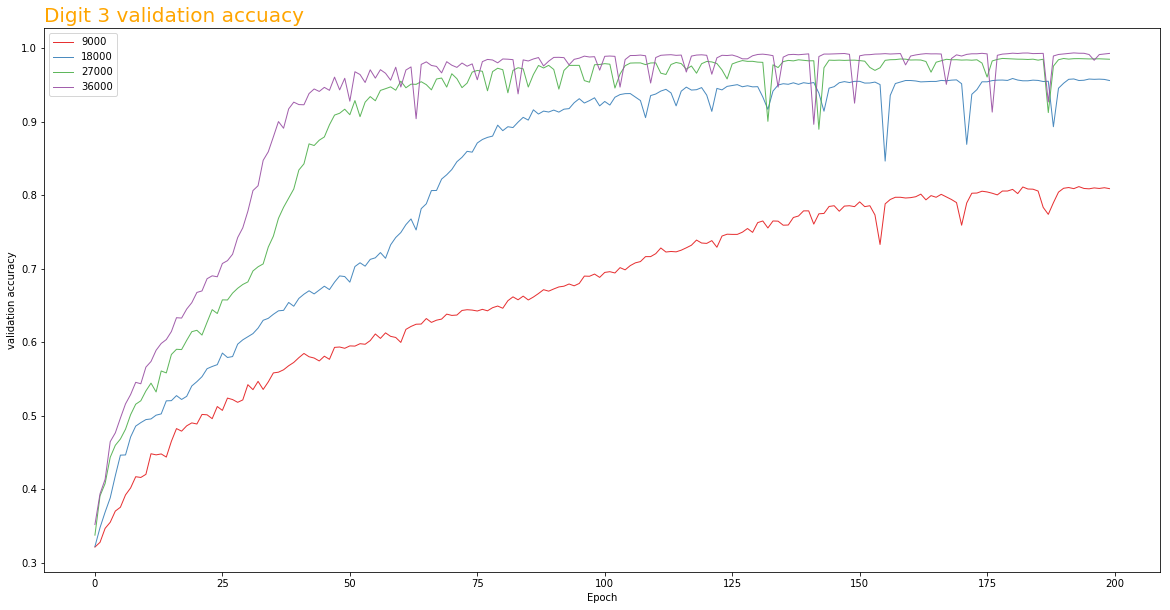

In [4]:
plt.figure(figsize=(20,10))

value = 'val_acc'
palette = plt.get_cmap('Set1')
plt.plot(d3s9[value], marker='', color=palette(0), linewidth=1, alpha=0.9, label='9000')
plt.plot(d3s18[value], marker='', color=palette(1), linewidth=1, alpha=0.9, label='18000')
plt.plot(d3s27[value], marker='', color=palette(2), linewidth=1, alpha=0.9, label='27000')
plt.plot(d3s36[value], marker='', color=palette(3), linewidth=1, alpha=0.9, label='36000')

plt.legend()

plt.title("Digit 3 validation accuacy", loc='left', fontsize=20, fontweight=0, color='orange')
plt.xlabel("Epoch")
plt.ylabel("validation accuracy")
plt.show()

可以觀察到，資料量越多，validation accuracy 上升越快。<br>
size 36000 大約在60Epoch時就可上升到0.98左右的準確度，<br>
size 27000 則可以在 80 epoch 左右到達0.98，<br>
而size 18000 也可以在 epoch 110後到達0.95左右<br>
size 9000 對於digit 3而言資料量較不足，即使到150 Epoch 也只能到0.8左右的準確度。

## Validation Loss

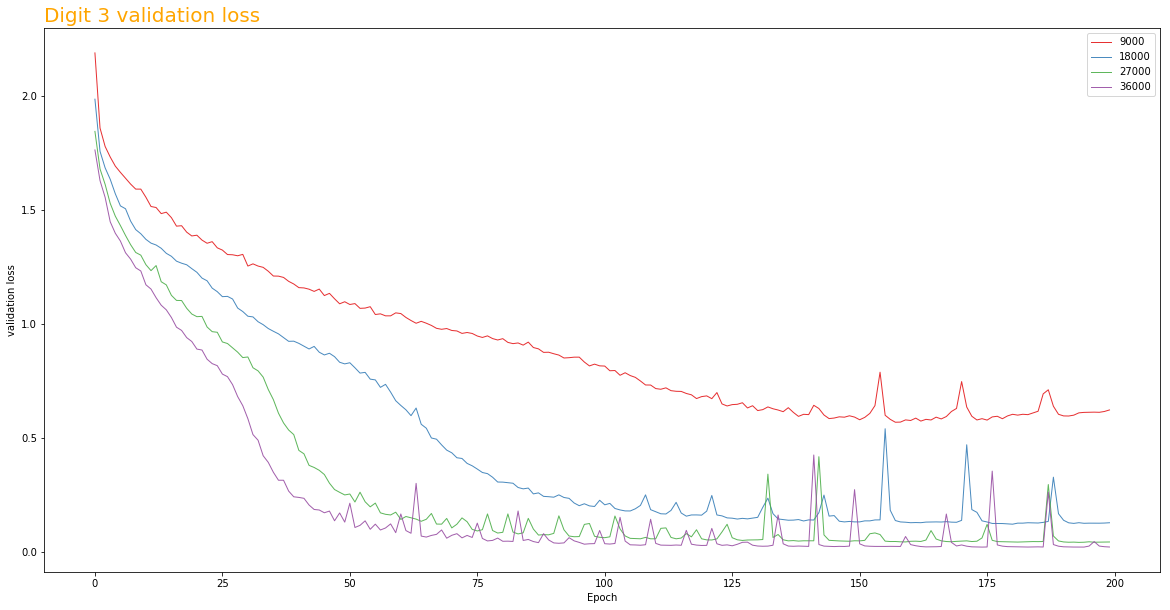

In [5]:
plt.figure(figsize=(20,10))

value = 'val_loss'
palette = plt.get_cmap('Set1')
plt.plot(d3s9[value], marker='', color=palette(0), linewidth=1, alpha=0.9, label='9000')
plt.plot(d3s18[value], marker='', color=palette(1), linewidth=1, alpha=0.9, label='18000')
plt.plot(d3s27[value], marker='', color=palette(2), linewidth=1, alpha=0.9, label='27000')
plt.plot(d3s36[value], marker='', color=palette(3), linewidth=1, alpha=0.9, label='36000')

plt.legend()

plt.title("Digit 3 validation loss", loc='left', fontsize=20, fontweight=0, color='orange')
plt.xlabel("Epoch")
plt.ylabel("validation loss")
plt.show()

Validation Loss 也可以觀察到相同的現象<br>
size 36000 與 27000 由於可以到達0.98 甚至0.99的準確度，而loss趨近於0.03左右，<br>
size 9000 loss 則下降最慢。

## Training Accuracy

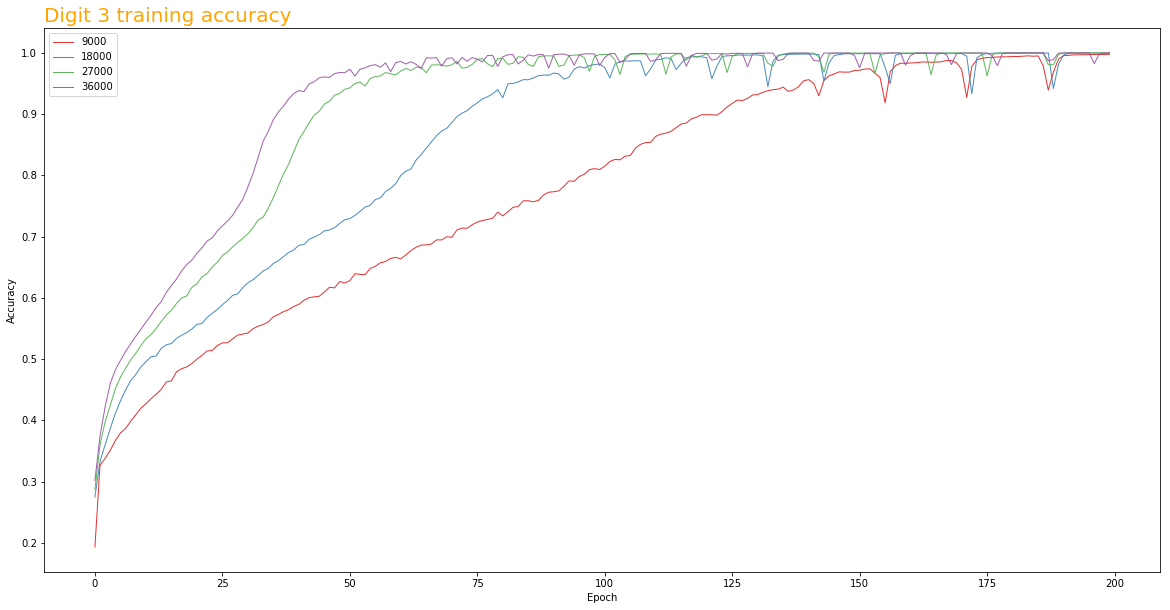

In [6]:
plt.figure(figsize=(20,10))

value = 'acc'
palette = plt.get_cmap('Set1')
plt.plot(d3s9[value], marker='', color=palette(0), linewidth=1, alpha=0.9, label='9000')
plt.plot(d3s18[value], marker='', color=palette(1), linewidth=1, alpha=0.9, label='18000')
plt.plot(d3s27[value], marker='', color=palette(2), linewidth=1, alpha=0.9, label='27000')
plt.plot(d3s36[value], marker='', color=palette(3), linewidth=1, alpha=0.9, label='36000')

plt.legend()

plt.title("Digit 3 training accuracy", loc='left', fontsize=20, fontweight=0, color='orange')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

Training Accuracy 上升趨勢與 Validation Accuracy 相反，但因為是accuracy 會overfitting，只要epoch越高，最終都能到達0.99的準確度。

## Training Loss

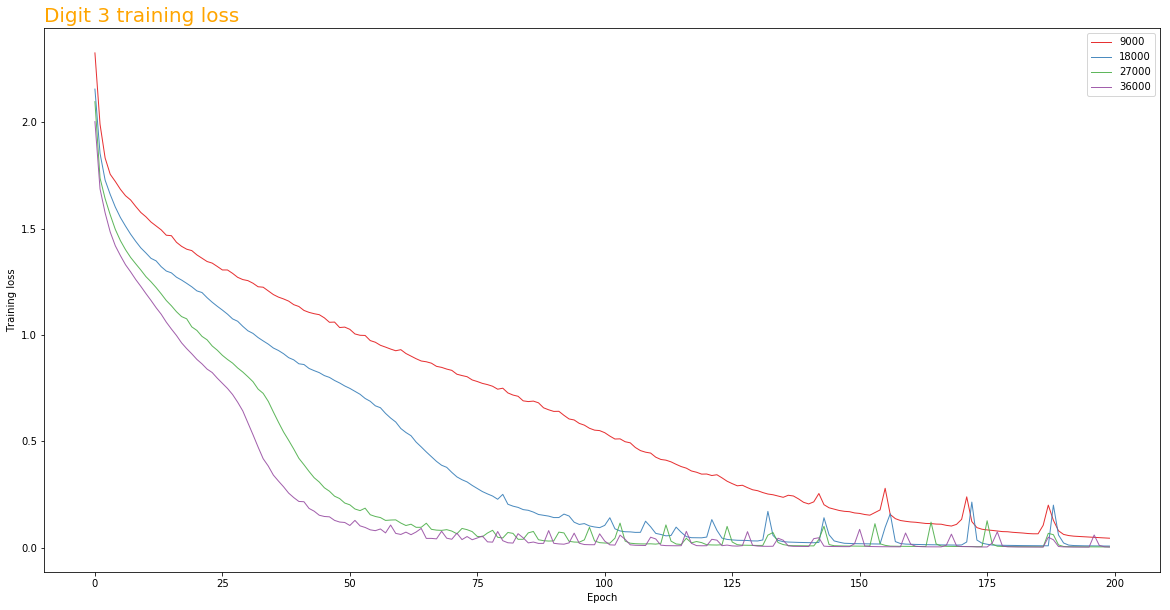

In [7]:
plt.figure(figsize=(20,10))

value = 'loss'
palette = plt.get_cmap('Set1')
plt.plot(d3s9[value], marker='', color=palette(0), linewidth=1, alpha=0.9, label='9000')
plt.plot(d3s18[value], marker='', color=palette(1), linewidth=1, alpha=0.9, label='18000')
plt.plot(d3s27[value], marker='', color=palette(2), linewidth=1, alpha=0.9, label='27000')
plt.plot(d3s36[value], marker='', color=palette(3), linewidth=1, alpha=0.9, label='36000')

plt.legend()

plt.title("Digit 3 training loss", loc='left', fontsize=20, fontweight=0, color='orange')
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.show()

Training Loss 下降趨勢也與 Training Accuracy 上升類似，size 36000 與 27000 大約可以在epoch 50 到達極值。

## TESTING ACCURACY

0    0.41536
1    0.85010
2    0.94280
3    0.97402
Name: test_acc, dtype: float64


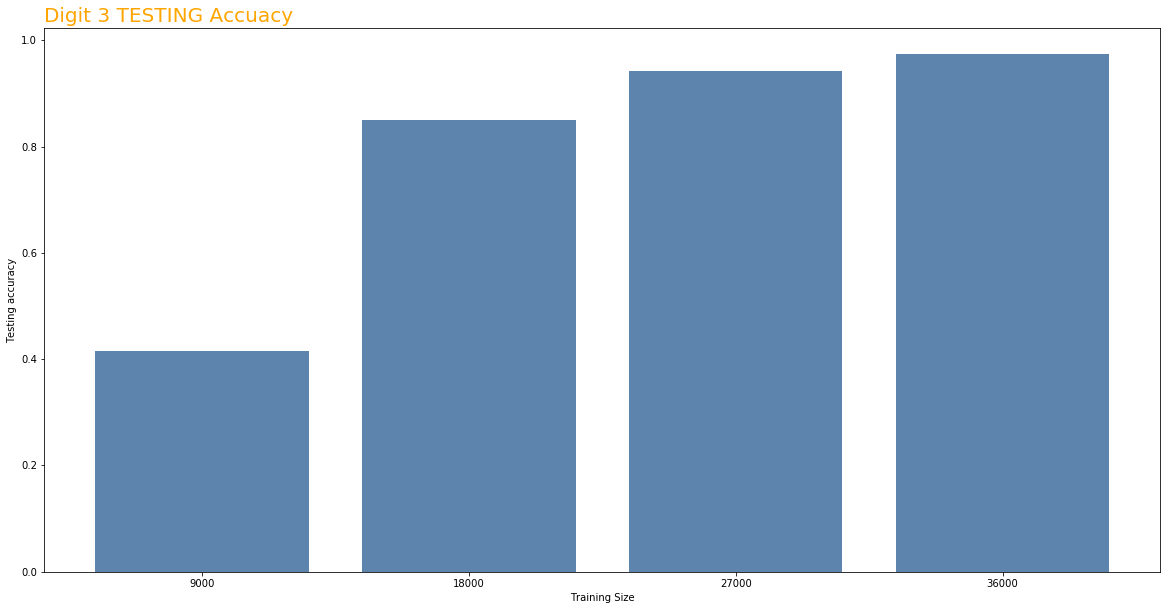

In [8]:
d3test_acc = pd.read_csv('./log/d3/test_d3_acc.csv')

print(d3test_acc['test_acc'])

plt.figure(figsize=(20,10))
bars = [9000,18000,27000,36000]

y_pos = np.arange(len(bars))
plt.bar(y_pos, d3test_acc['test_acc'], color=(0.2, 0.4, 0.6, 0.8))
plt.xticks(y_pos, bars)

plt.title("Digit 3 TESTING Accuacy", loc='left', fontsize=20, fontweight=0, color='orange')
plt.xlabel("Training Size")
plt.ylabel("Testing accuracy")
plt.show()

當資料量為 27000（總可能數之0.027）時最終便可在Testing Data 達到0.94的準確度。

## DIGIT 4

In [9]:
# Read Data
d4s9 = pd.read_csv('./log/d4/s9.csv')
d4s18 = pd.read_csv('./log/d4/s18.csv')
d4s27 = pd.read_csv('./log/d4/s27.csv')
d4s36 = pd.read_csv('./log/d4/s36.csv')

## Digit 4 Validation Accuracy

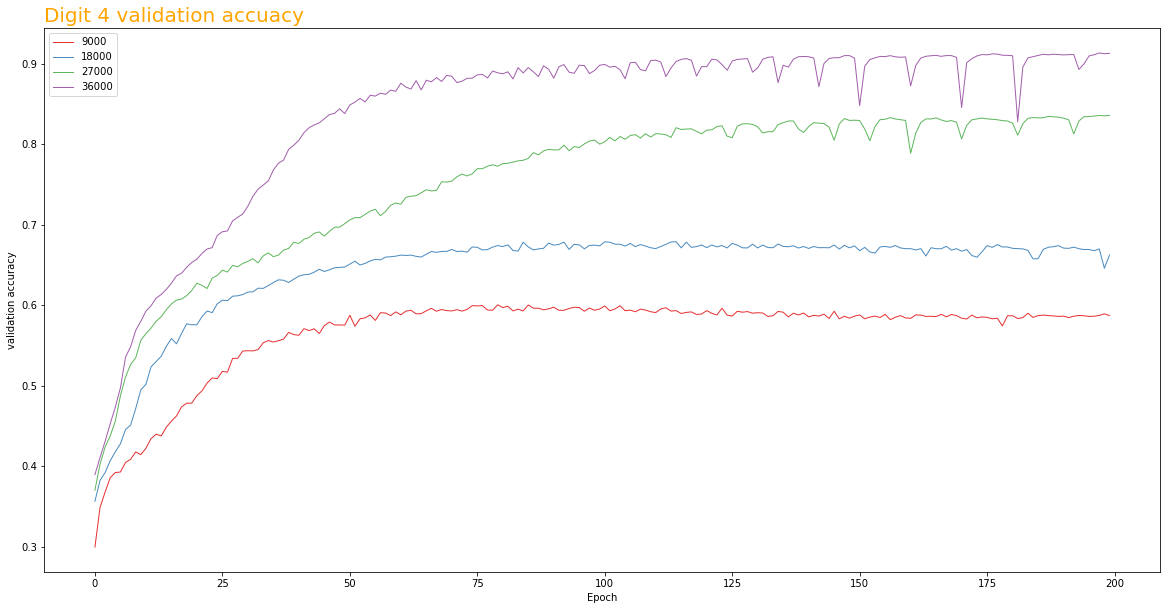

In [10]:
plt.figure(figsize=(20,10))

value = 'val_acc'
palette = plt.get_cmap('Set1')
plt.plot(d4s9[value], marker='', color=palette(0), linewidth=1, alpha=0.9, label='9000')
plt.plot(d4s18[value], marker='', color=palette(1), linewidth=1, alpha=0.9, label='18000')
plt.plot(d4s27[value], marker='', color=palette(2), linewidth=1, alpha=0.9, label='27000')
plt.plot(d4s36[value], marker='', color=palette(3), linewidth=1, alpha=0.9, label='36000')

plt.legend()

plt.title("Digit 4 validation accuacy", loc='left', fontsize=20, fontweight=0, color='orange')
plt.xlabel("Epoch")
plt.ylabel("validation accuracy")
plt.show()

在四位數的狀況下，在9000, 18000, 27000, 36000資料量時準確度上升趨勢是接近的，到達極值的epoch也是接近的，僅是終值差異的不同。<br>
size 為 36000的情況下最終也可到達0.9的準確度。

## Digit 4 Validation Loss

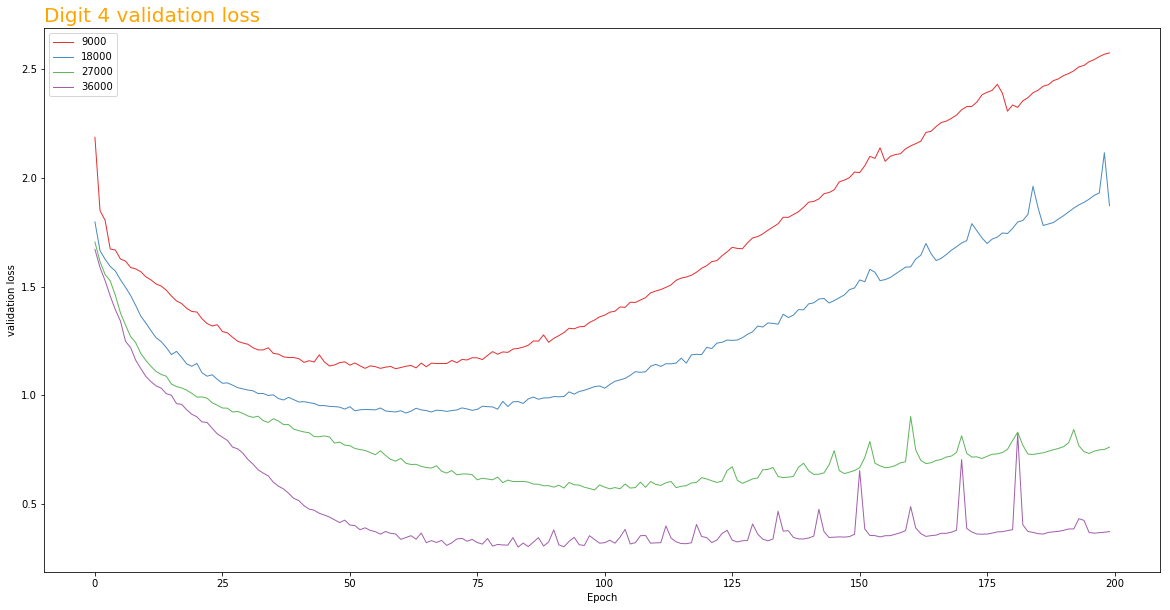

In [11]:
plt.figure(figsize=(20,10))

value = 'val_loss'
palette = plt.get_cmap('Set1')
plt.plot(d4s9[value], marker='', color=palette(0), linewidth=1, alpha=0.9, label='9000')
plt.plot(d4s18[value], marker='', color=palette(1), linewidth=1, alpha=0.9, label='18000')
plt.plot(d4s27[value], marker='', color=palette(2), linewidth=1, alpha=0.9, label='27000')
plt.plot(d4s36[value], marker='', color=palette(3), linewidth=1, alpha=0.9, label='36000')

plt.legend()

plt.title("Digit 4 validation loss", loc='left', fontsize=20, fontweight=0, color='orange')
plt.xlabel("Epoch")
plt.ylabel("validation loss")
plt.show()

由於資料量不足，size 9000 與 size 18000，最終準確度僅有0.6, 0.7的情況下，其 validation_loss 在epoch 超過 75後甚至會有上升的情況。

## Digit 4 Training Accuracy

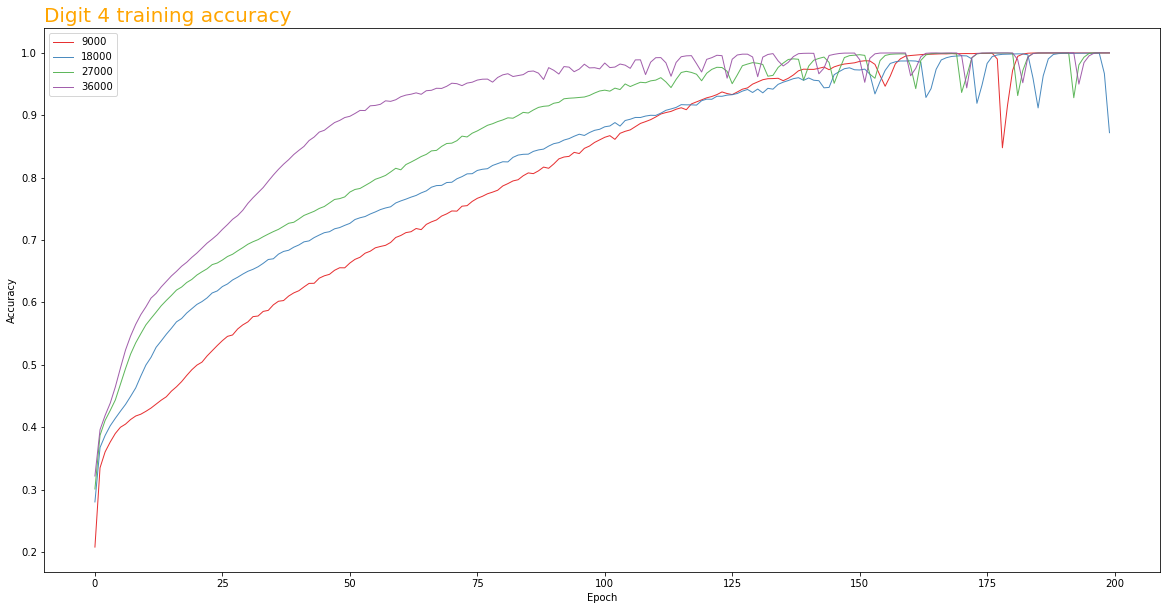

In [12]:
plt.figure(figsize=(20,10))

value = 'acc'
palette = plt.get_cmap('Set1')
plt.plot(d4s9[value], marker='', color=palette(0), linewidth=1, alpha=0.9, label='9000')
plt.plot(d4s18[value], marker='', color=palette(1), linewidth=1, alpha=0.9, label='18000')
plt.plot(d4s27[value], marker='', color=palette(2), linewidth=1, alpha=0.9, label='27000')
plt.plot(d4s36[value], marker='', color=palette(3), linewidth=1, alpha=0.9, label='36000')

plt.legend()

plt.title("Digit 4 training accuracy", loc='left', fontsize=20, fontweight=0, color='orange')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

Training Accuracy 大約在 100~130 Epoch 都可達到0.99的準確度，但考量到validation accuracy，基本上已經overfitting。

## Digit 4 Training Loss

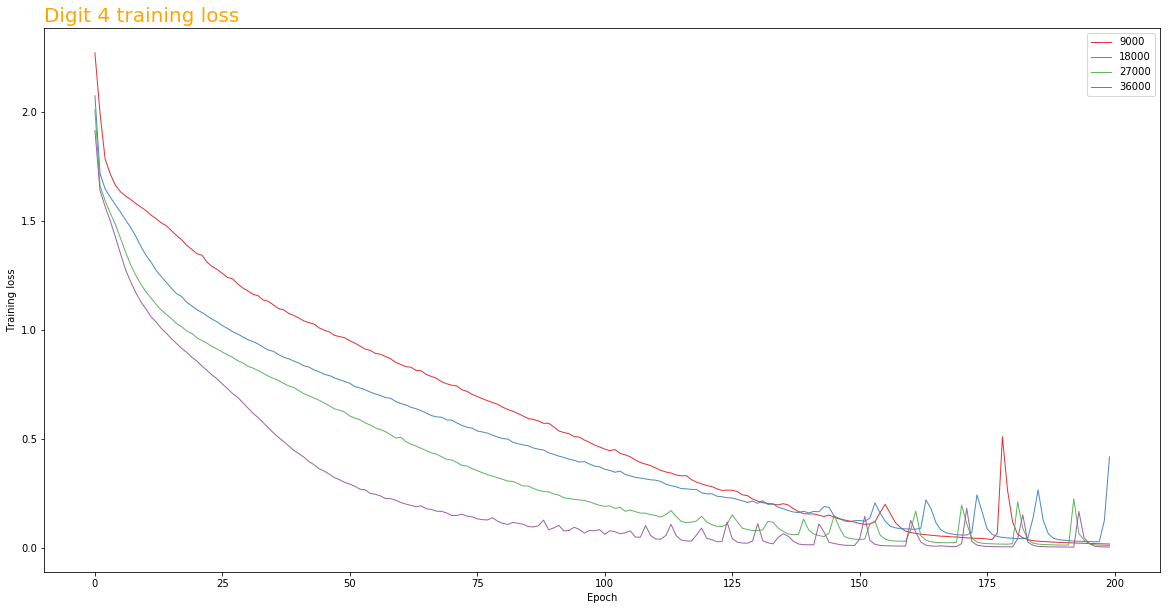

In [13]:
plt.figure(figsize=(20,10))

value = 'loss'
palette = plt.get_cmap('Set1')
plt.plot(d4s9[value], marker='', color=palette(0), linewidth=1, alpha=0.9, label='9000')
plt.plot(d4s18[value], marker='', color=palette(1), linewidth=1, alpha=0.9, label='18000')
plt.plot(d4s27[value], marker='', color=palette(2), linewidth=1, alpha=0.9, label='27000')
plt.plot(d4s36[value], marker='', color=palette(3), linewidth=1, alpha=0.9, label='36000')

plt.legend()

plt.title("Digit 4 training loss", loc='left', fontsize=20, fontweight=0, color='orange')
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.show()

因為是Training Loss ，並沒有出現像validation loss那樣的後期上升狀況，而資料量越多，下降速度越快。

## Digit 4 Testing Accuracy

0    0.03108
1    0.09666
2    0.45794
3    0.69044
Name: test_acc, dtype: float64


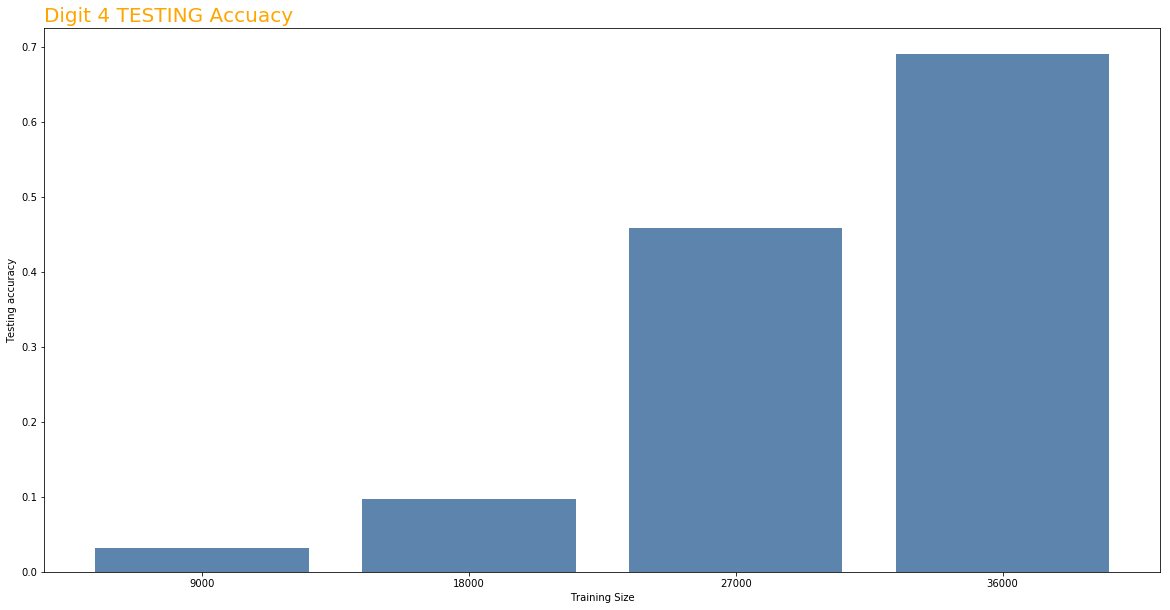

In [14]:
d4test_acc = pd.read_csv('./log/d4/test_d4_acc.csv')

print(d4test_acc['test_acc'])

plt.figure(figsize=(20,10))
bars = [9000,18000,27000,36000]

y_pos = np.arange(len(bars))
plt.bar(y_pos, d4test_acc['test_acc'], color=(0.2, 0.4, 0.6, 0.8))
plt.xticks(y_pos, bars)

plt.title("Digit 4 TESTING Accuacy", loc='left', fontsize=20, fontweight=0, color='orange')
plt.xlabel("Training Size")
plt.ylabel("Testing accuracy")
plt.show()

可以看到在四位數的情況，準確度的差異很明顯，size 為 36000（所有可能之0.0003）的情況最終僅能到達0.69的準確度，但資料量若再提升，準確度應可繼續提高。